Epoch[1/100], G Loss: 1.1946, D Loss: 7.7570


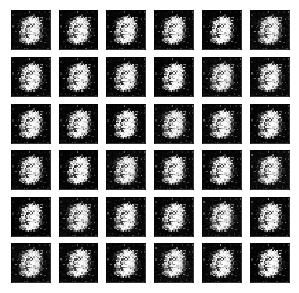

Epoch[2/100], G Loss: 0.8359, D Loss: 7.8991


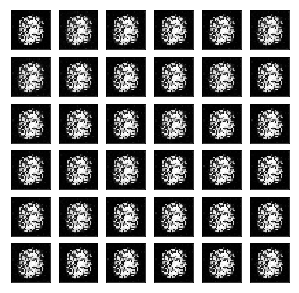

Epoch[3/100], G Loss: 0.6774, D Loss: 7.6693


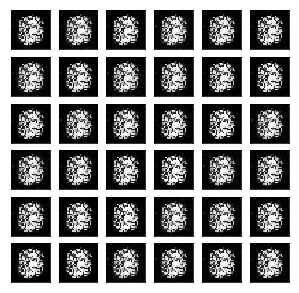

Epoch[4/100], G Loss: 0.7066, D Loss: 8.6576


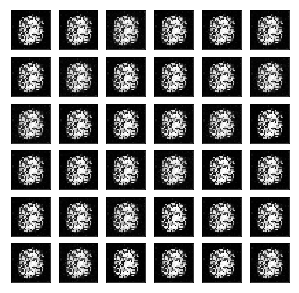

Epoch[5/100], G Loss: 0.7393, D Loss: 8.9743


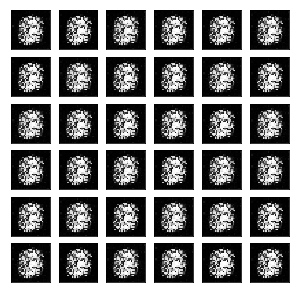

Epoch[6/100], G Loss: 0.7619, D Loss: 9.1135


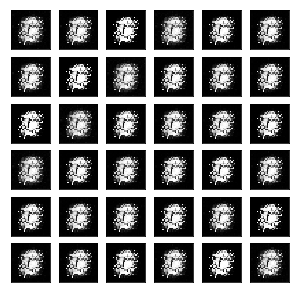

Epoch[7/100], G Loss: 0.7913, D Loss: 9.0301


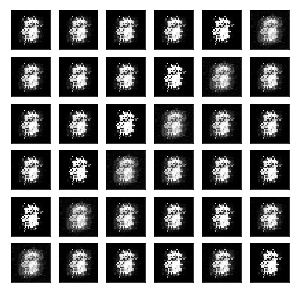

Epoch[8/100], G Loss: 0.8122, D Loss: 9.0052


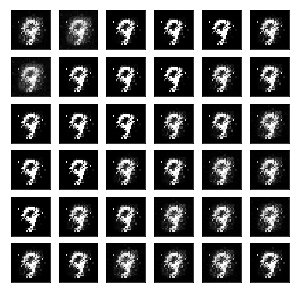

Epoch[9/100], G Loss: 0.7893, D Loss: 9.0712


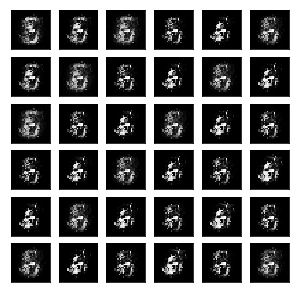

Epoch[10/100], G Loss: 0.7020, D Loss: 9.1750


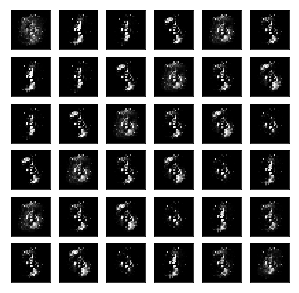

Epoch[11/100], G Loss: 0.7280, D Loss: 8.9179


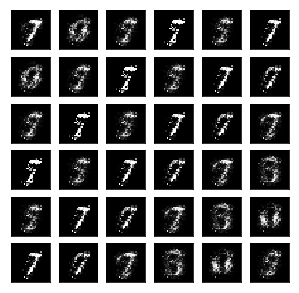

Epoch[12/100], G Loss: 0.7215, D Loss: 8.9405


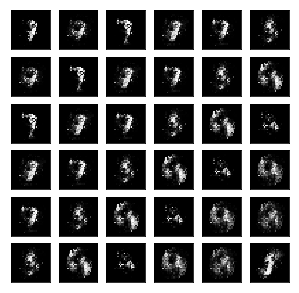

Epoch[13/100], G Loss: 0.7261, D Loss: 8.8431


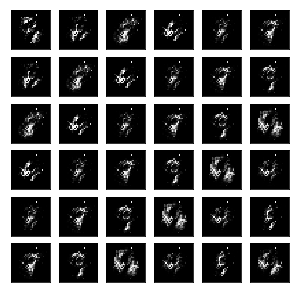

Epoch[14/100], G Loss: 0.6929, D Loss: 8.9172


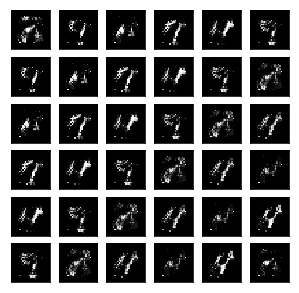

Epoch[15/100], G Loss: 0.6805, D Loss: 8.8539


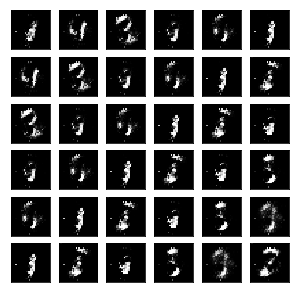

Epoch[16/100], G Loss: 0.6942, D Loss: 8.6673


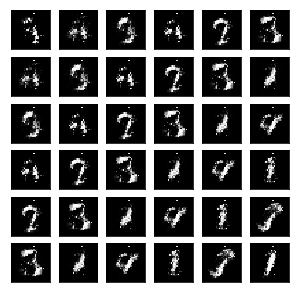

Epoch[17/100], G Loss: 0.7127, D Loss: 7.4371


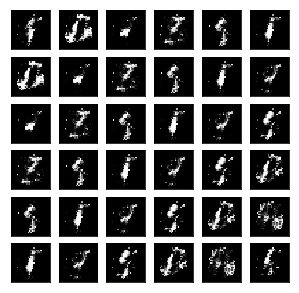

Epoch[18/100], G Loss: 0.9504, D Loss: 6.7809


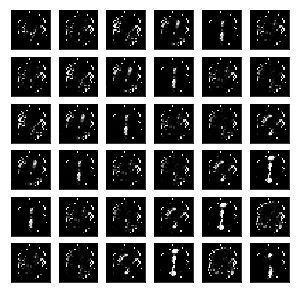

Epoch[19/100], G Loss: 1.3745, D Loss: 3.1339


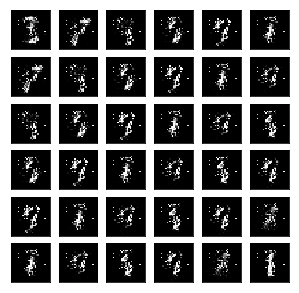

Epoch[20/100], G Loss: 1.0586, D Loss: 3.6162


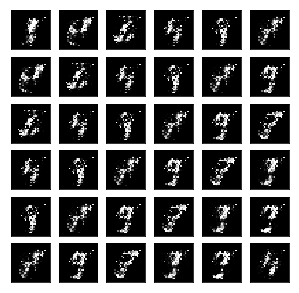

Epoch[21/100], G Loss: 1.2488, D Loss: 3.3499


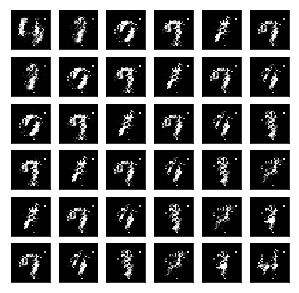

Epoch[22/100], G Loss: 1.3290, D Loss: 2.1732


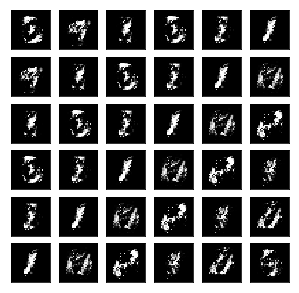

Epoch[23/100], G Loss: 1.4722, D Loss: 1.2066


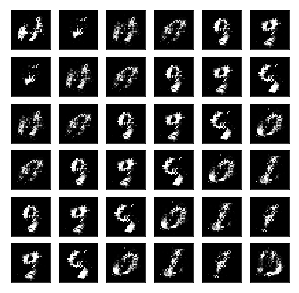

Epoch[24/100], G Loss: 1.6096, D Loss: 1.1532


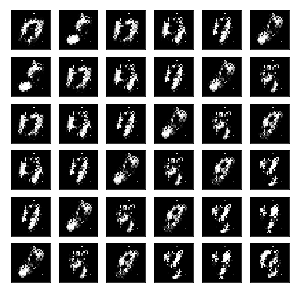

Epoch[25/100], G Loss: 1.7230, D Loss: 1.0685


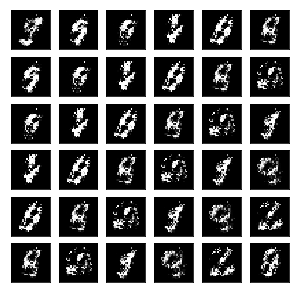

Epoch[26/100], G Loss: 1.7619, D Loss: 1.0424


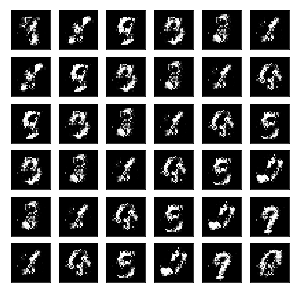

Epoch[27/100], G Loss: 1.8032, D Loss: 1.0150


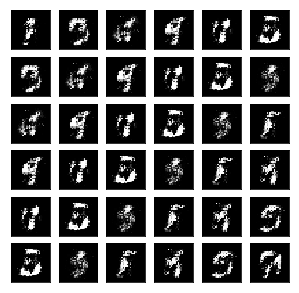

Epoch[28/100], G Loss: 1.8463, D Loss: 0.9951


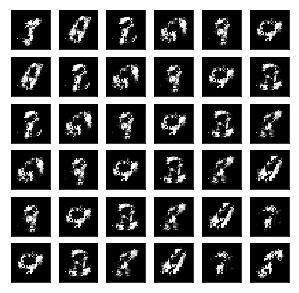

Epoch[29/100], G Loss: 1.9210, D Loss: 0.9440


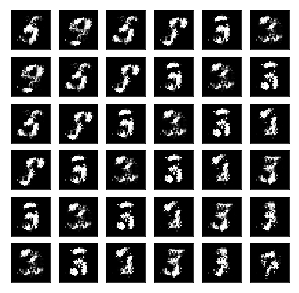

Epoch[30/100], G Loss: 1.8674, D Loss: 0.9761


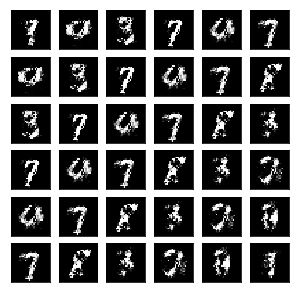

Epoch[31/100], G Loss: 1.8585, D Loss: 0.9432


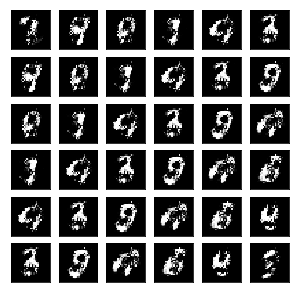

Epoch[32/100], G Loss: 1.8767, D Loss: 0.9075


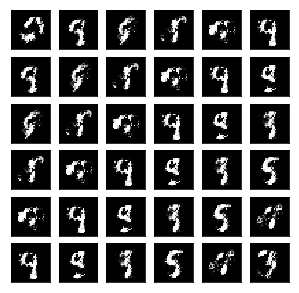

Epoch[33/100], G Loss: 1.9227, D Loss: 0.9003


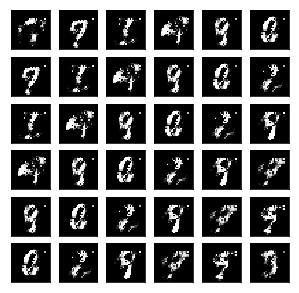

Epoch[34/100], G Loss: 1.9292, D Loss: 0.8510


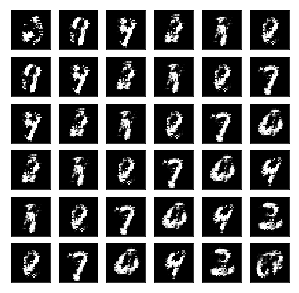

Epoch[35/100], G Loss: 1.9445, D Loss: 0.8514


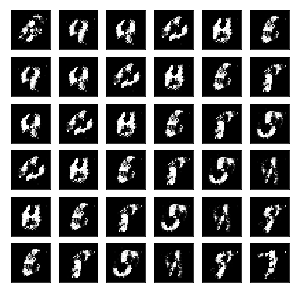

Epoch[36/100], G Loss: 1.8842, D Loss: 0.8678


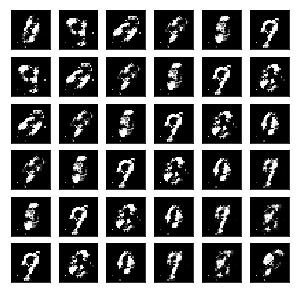

Epoch[37/100], G Loss: 1.8511, D Loss: 0.8943


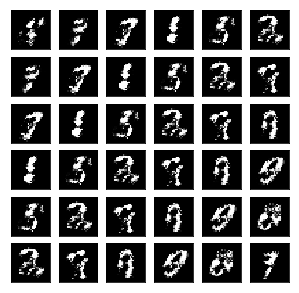

Epoch[38/100], G Loss: 1.9432, D Loss: 0.9547


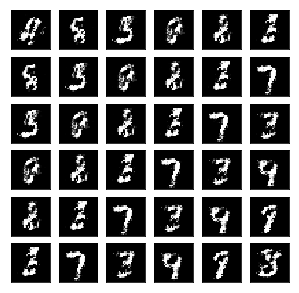

Epoch[39/100], G Loss: 1.9222, D Loss: 1.1392


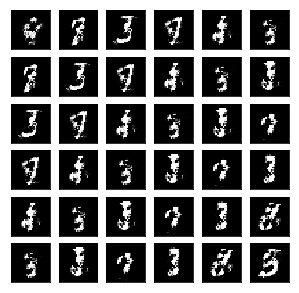

Epoch[40/100], G Loss: 1.9301, D Loss: 1.2282


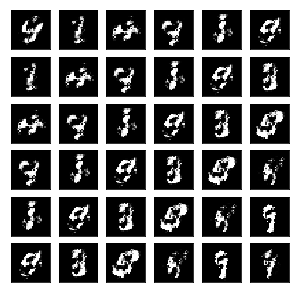

Epoch[41/100], G Loss: 1.9320, D Loss: 1.0114


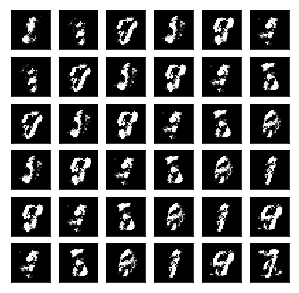

Epoch[42/100], G Loss: 1.9188, D Loss: 0.8717


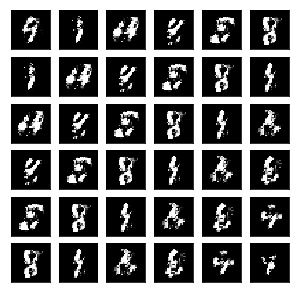

Epoch[43/100], G Loss: 1.9132, D Loss: 0.7960


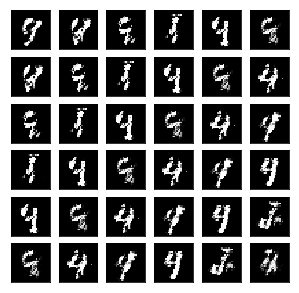

Epoch[44/100], G Loss: 1.9270, D Loss: 0.7553


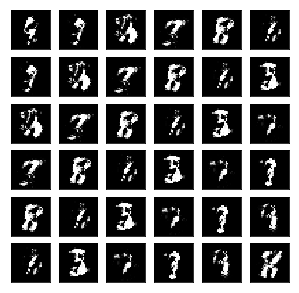

Epoch[45/100], G Loss: 1.8602, D Loss: 0.7734


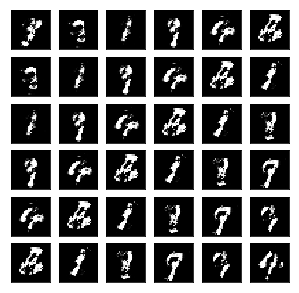

Epoch[46/100], G Loss: 1.8417, D Loss: 0.7876


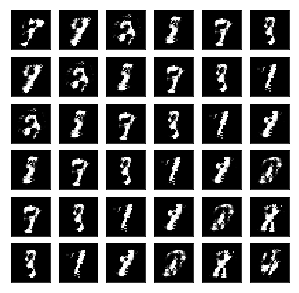

Epoch[47/100], G Loss: 1.8497, D Loss: 0.7845


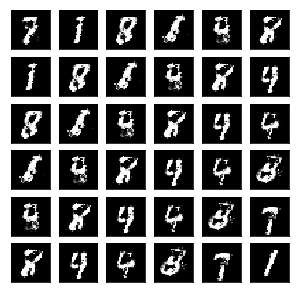

Epoch[48/100], G Loss: 1.8833, D Loss: 0.7723


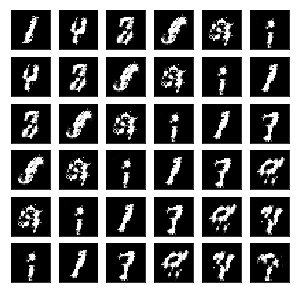

Epoch[49/100], G Loss: 1.8971, D Loss: 0.7725


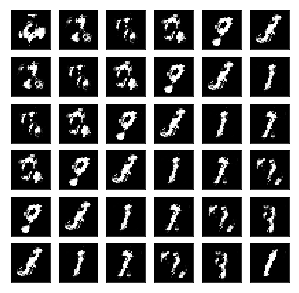

Epoch[50/100], G Loss: 1.8673, D Loss: 0.7961


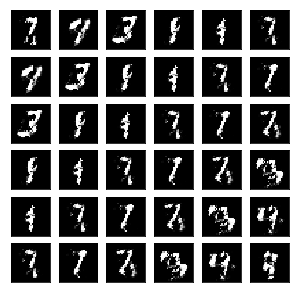

Epoch[51/100], G Loss: 1.8720, D Loss: 0.7967


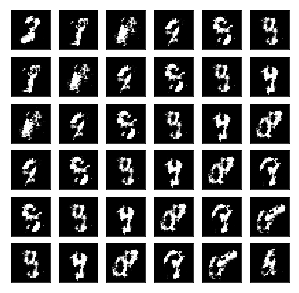

Epoch[52/100], G Loss: 1.9186, D Loss: 0.8092


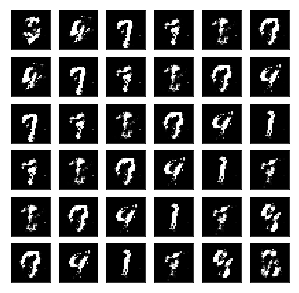

Epoch[53/100], G Loss: 1.8983, D Loss: 0.8232


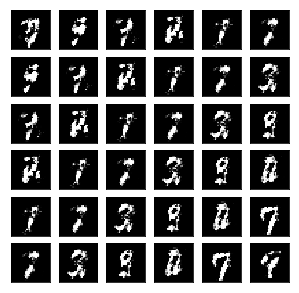

Epoch[54/100], G Loss: 1.9066, D Loss: 0.8235


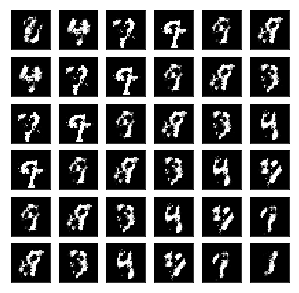

KeyboardInterrupt: 

In [3]:
""" (DRAGAN)
Deep Regret Analytic GAN

https://arxiv.org/pdf/1705.07215.pdf

The output of DRAGAN's D can be interpretted as a probability, similarly to MMGAN
and NSGAN.

Proposes to study GANs from a regret minimization perspective. This implementation is 
very similar to WGAN GP, in that it is applying a gradient penalty to try and get at 
an improved training objective based on how D and G would optimally perform. They apply 
the gradient penalty only close to the real data manifold (whereas WGAN GP picks the 
gradient location on a random line between a real and randomly generated fake sample). 
For further details, see Section 2.5 of the paper.

DRAGAN is very similar to WGANGP, but seems much less stable. I would spend more time on
WGANGP than DRAGAN.
"""

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from tqdm import tqdm_notebook
from load_data import get_data


def to_var(x):
    """ Make a tensor cuda-erized and requires gradient """
    return to_cuda(x).requires_grad_()

def to_cuda(x):
    """ Cuda-erize a tensor """
    if torch.cuda.is_available():
        x = x.cuda()
    return x

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()


class Generator(nn.Module):
    """ Generator. Input is noise, output is a generated image. 
    """
    def __init__(self, image_size, hidden_dim, z_dim):
        super().__init__()
        
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = F.sigmoid(self.generate(activated))
        return generation


class Discriminator(nn.Module):
    """ Critic (not trained to classify). Input is an image (real or generated), 
    output is the approximate Wasserstein Distance between z~P(G(z)) and real.
    """
    def __init__(self, image_size, hidden_dim, output_dim):
        super().__init__()
        
        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminate = nn.Linear(hidden_dim, output_dim)     
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = F.sigmoid(self.discriminate(activated))
        return discrimination


class DRAGAN(nn.Module):
    """ Super class to contain both Discriminator (D) and Generator (G) 
    """
    def __init__(self, image_size, hidden_dim, z_dim, output_dim=1):
        super().__init__()
        
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim, output_dim)
        
        self.z_dim = z_dim


class DRAGANTrainer:
    """ Object to hold data iterators, train a GAN variant 
    """
    def __init__(self, model, train_iter, val_iter, test_iter, viz=False):
        self.model = to_cuda(model)
        self.name = model.__class__.__name__
        
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
        
        self.Glosses = []
        self.Dlosses = []
        
        self.viz = viz

    def train(self, num_epochs, G_lr=1e-4, D_lr=1e-4, D_steps=5):
        """ Train a Deep Regret Analytic GAN
            Logs progress using G loss, D loss, G(x), D(G(x)), visualizations of Generator output.

        Inputs:
            num_epochs: int, number of epochs to train for
            G_lr: float, learning rate for generator's Adam optimizer (default 1e-4)
            D_lr: float, learning rate for discriminator's Adam optimizer (default 1e-4)
            D_steps: int, training step ratio for how often to train D compared to G (default 5)
        """
        # Initialize optimizers
        G_optimizer = torch.optim.Adam(params=[p for p in self.model.G.parameters() if p.requires_grad], lr=G_lr)
        D_optimizer = torch.optim.Adam(params=[p for p in self.model.D.parameters() if p.requires_grad], lr=D_lr)
    
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
        # Begin training
        for epoch in tqdm_notebook(range(1, num_epochs+1)):
            self.model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                for _ in range(D_steps): 

                    # Reshape images
                    images = self.process_batch(self.train_iter)

                    # TRAINING D: Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Train the discriminator to approximate the Wasserstein distance between real, generated
                    # distributions                    
                    D_loss = self.train_D(images)
                    
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Log results, backpropagate the discriminator network
                    D_step_loss.append(D_loss.item())
                                                        
                # We report D_loss in this way so that G_loss and D_loss have the same number of entries.
                D_losses.append(np.mean(D_step_loss))
                
                # TRAINING G: Zero out gradients for G
                G_optimizer.zero_grad()

                # Train the generator to (roughly) minimize the approximated Wasserstein distance
                G_loss = self.train_G(images)
                
                # Log results, update parameters
                G_losses.append(G_loss.item())
                G_loss.backward()
                G_optimizer.step()
            
            # Save progress
            self.Glosses.extend(G_losses)
            self.Dlosses.extend(D_losses)
                            
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses))) 
            
            # Visualize generator progress
            self.generate_images(epoch)
            
            if self.viz:
                plt.show()       
        
    def train_D(self, images, LAMBDA=10, K=1, C=1):
        """ Run 1 step of training for discriminator

        Input:
            model: model instantiation
            images: batch of images (reshaped to [batch_size, 784])
        Output:
            D_loss: DRAGAN loss for discriminator, -E[log(D(x))] - E[log(1 - D(G(z)))] + λE[(||∇ D(G(z))|| - 1)^2]
        """     
        
        # NON-SATURATING LOSS STEPS:
        # Generate labels for the real and generated images (real is 1, generated is 0)
        X_labels = to_cuda(torch.ones(images.shape[0], 1)) 
        G_labels = to_cuda(torch.zeros(images.shape[0], 1))
        
        # Classify the real batch images, get the loss for these 
        DX_score = self.model.D(images)
        DX_loss = F.binary_cross_entropy(DX_score, X_labels)
        
        # Sample outputs from the generator
        noise = self.compute_noise(images.shape[0], self.model.z_dim)
        G_output = self.model.G(noise)
        
        # Classify the fake batch images, get the loss for these (labels being all 0, since they are fake)
        DG_score = self.model.D(G_output)
        DG_loss = F.binary_cross_entropy(DG_score, G_labels)
        
        # GRADIENT PENALTY STEPS:
        # Uniformly sample along one straight line per each batch entry. 
        delta = to_cuda(torch.rand(images.shape[0], 1).expand(images.size()))

        # Generate images from the noise, ensure unit 
        G_interpolation = to_var(delta*images.data + (1-delta) * 
                                 (images.data + C*images.data.std() * torch.rand(images.size())))

        # Discriminate generator interpolation
        D_interpolation = self.model.D(G_interpolation)

        # Compute the gradients of D with respect to the noise generated input
        gradients = torch.autograd.grad(outputs = D_interpolation, 
                                        inputs = G_interpolation,
                                        grad_outputs = to_cuda(torch.ones(D_interpolation.size())),
                                        only_inputs = True,
                                        create_graph = True,
                                        retain_graph = True)[0]

        # Full gradient penalty
        grad_penalty = LAMBDA * torch.mean((gradients.norm(2, dim=1) - K)**2)
        
        # Compute DRAGAN loss for D
        D_loss = DX_loss + DG_loss + grad_penalty
        
        return D_loss
    
    def train_G(self, images):
        """ Run 1 step of training for generator
        
        Input:
            images: batch of images (reshaped to [batch_size, -1]) 
        Output:
            G_loss: DRAGAN (non-saturating) loss for G, -E[log(D(G(z)))]
        """   
        # Generate labels for the generator batch images (all 0, since they are fake)
        G_labels = to_cuda(torch.ones(images.shape[0], 1)) 
        
        # Get noise, classify it using G, then classify the output of G using D.
        G_noise = self.compute_noise(images.shape[0], self.model.z_dim) # z
        G_output = self.model.G(G_noise) # G(z)
        DG_score = self.model.D(G_output) # D(G(z))
        
        # Compute non-saturating G loss
        G_loss = F.binary_cross_entropy(DG_score, G_labels)
        
        return G_loss
    
    def compute_noise(self, batch_size, z_dim):
        """ Compute random noise for the generator to learn to make images from """
        return to_cuda(torch.randn(batch_size, z_dim))
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_cuda(images.view(images.shape[0], -1))
        return images
    
    def generate_images(self, epoch, num_outputs=36, save=True):
        """ Visualize progress of generator learning """
        # Turn off any regularization
        self.model.eval()
        
        # Sample noise vector
        noise = self.compute_noise(num_outputs, self.model.z_dim)
        
        # Transform noise to image
        images = self.model.G(noise)
        
        # Reshape to proper image size
        images = images.view(images.shape[0], 28, 28)
        
        # Plot
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        # Save images if desired
        if save:
            outname = '../viz/' + self.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            torchvision.utils.save_image(images.unsqueeze(1).data.cpu(), 
                                         outname + 'reconst_%d.png'
                                         %(epoch), nrow = 5)
    
    def viz_loss(self):
        """ Visualize loss for the generator, discriminator """
        plt.style.use('ggplot')
        plt.rcParams["figure.figsize"] = (8,6)

        plt.plot(self.Dlosses, 'r')
        plt.plot(self.Glosses, 'g')
        
        plt.legend(['Discriminator', 'Generator'])
        plt.title(self.name)
        plt.show()

    def save_model(self, savepath):
        """ Save model state dictionary """
        torch.save(self.model.state_dict(), savepath)
    
    def load_model(self, loadpath):
        """ Load state dictionary into model """
        state = torch.load(loadpath)
        self.model.load_state_dict(state)


model = DRAGAN(image_size=784, 
               hidden_dim=256, 
               z_dim=128)

trainer = DRAGANTrainer(model=model, 
                        train_iter=train_iter, 
                        val_iter=val_iter, 
                        test_iter=test_iter,
                        viz=True)

trainer.train(num_epochs=65,
              G_lr=1e-4,
              D_lr=1e-4,
              D_steps=1)